In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# Ruta de los datos y archivo
data_dir = '/Users/alanmagno/Documents/datascience_paradigmas/datasets/covid/train_2'
data_file = '/Users/alanmagno/Documents/datascience_paradigmas/datasets/covid/datos_redimensionados_entrenamiento.txt'

# 1. Cargar las etiquetas desde el archivo de texto
def cargar_etiquetas(data_file):
    data = pd.read_csv(data_file, sep=' ', header=None, names=['path', 'label', 'patient_id'])
    data['path'] = data['path'].apply(lambda x: os.path.join(data_dir, x.split('/')[-1]))  # Combina con el nombre de archivo
    data['label'] = data['label'].map({'positive': 1, 'negative': 0})  # Codificar etiquetas
    return data

# 2. Preprocesar imágenes
def cargar_imagenes(data, image_size=(50, 50)):
    imagenes = []
    etiquetas = []
    for _, row in data.iterrows():
        img_path, label = row['path'], row['label']
        if os.path.exists(img_path):  # Verifica que la ruta de la imagen existe
            img = Image.open(img_path).convert('L').resize(image_size)  # Escala a escala de grises y cambia de tamaño
            imagenes.append(np.array(img).flatten())  # Aplanar la imagen
            etiquetas.append(label)
        else:
            print(f"Advertencia: la imagen no se encontró en {img_path}")
    return np.array(imagenes), np.array(etiquetas)

# Cargar datos y preprocesar
data = cargar_etiquetas(data_file)
imagenes, etiquetas = cargar_imagenes(data)

# Normalización de las imágenes
scaler = StandardScaler()
imagenes_normalizadas = scaler.fit_transform(imagenes)

# 3. Reducción de características con PCA
pca = PCA(n_components=100)
imagenes_pca = pca.fit_transform(imagenes_normalizadas)

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes_pca, etiquetas, test_size=0.3, random_state=42)

# 4. Agrupamiento con k-means
kmeans = KMeans(n_clusters=2, random_state=42)  # Definimos dos clusters, uno para cada clase
kmeans.fit(X_train)

# Predecir etiquetas para el conjunto de prueba
predicciones = kmeans.predict(X_test)

# Mapear clusters a etiquetas verdaderas
from scipy.stats import mode

def map_clusters_to_labels(y_true, y_pred):
    labels = np.zeros_like(y_pred)
    for cluster in np.unique(y_pred):
        mask = (y_pred == cluster)
        labels[mask] = mode(y_true[mask])[0]
    return labels

# Asignar etiquetas basadas en los clusters
predicciones_asignadas = map_clusters_to_labels(y_test, predicciones)

# 5. Evaluar precisión del modelo
precision_kmeans = accuracy_score(y_test, predicciones_asignadas)
print(f"Precisión de k-means: {precision_kmeans:.2f}")


Advertencia: la imagen no se encontró en /Users/alanmagno/Documents/datascience_paradigmas/datasets/covid/train_2/path_redimensionada
Precisión de k-means: 0.85


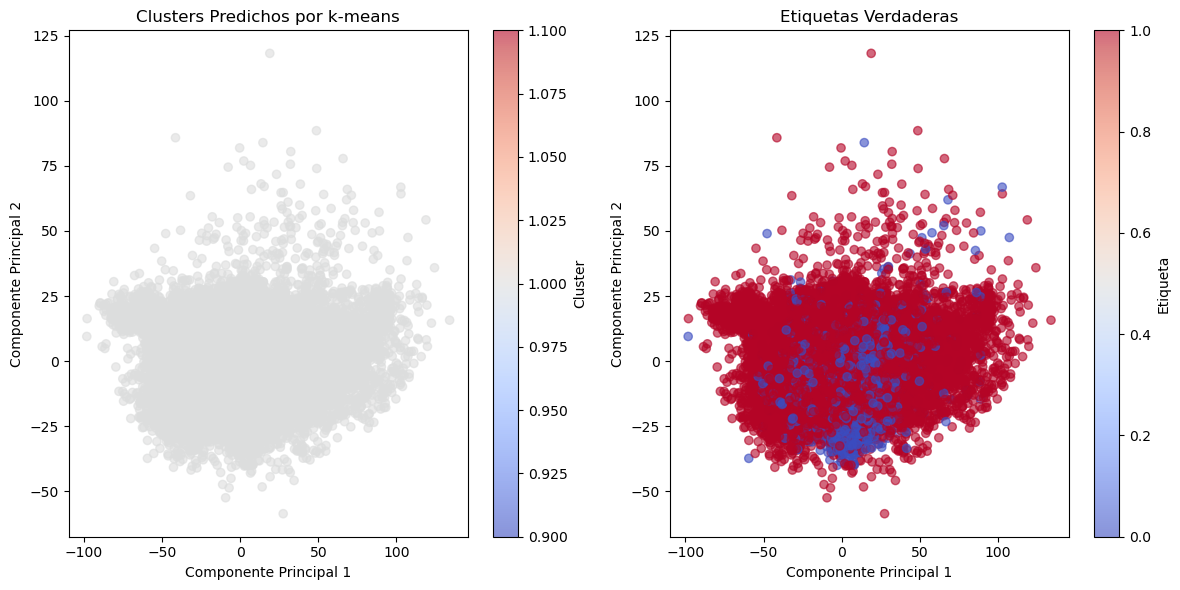

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reducir a 2 componentes para visualización
pca_viz = PCA(n_components=100)
X_train_viz = pca_viz.fit_transform(X_train)
X_test_viz = pca_viz.transform(X_test)

# Predicción de k-means en 2D
kmeans_viz = KMeans(n_clusters=2, random_state=42)
kmeans_viz.fit(X_train_viz)
predicciones_viz = kmeans_viz.predict(X_test_viz)

# Asignación de etiquetas de clusters a las etiquetas verdaderas en 2D
predicciones_asignadas_viz = map_clusters_to_labels(y_test, predicciones_viz)

# Graficar los resultados
plt.figure(figsize=(12, 6))

# Clusters predichos
plt.subplot(1, 2, 1)
plt.scatter(X_test_viz[:, 0], X_test_viz[:, 1], c=predicciones_asignadas_viz, cmap='coolwarm', alpha=0.6)
plt.title('Clusters Predichos por k-means')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')

# Etiquetas verdaderas
plt.subplot(1, 2, 2)
plt.scatter(X_test_viz[:, 0], X_test_viz[:, 1], c=y_test, cmap='coolwarm', alpha=0.6)
plt.title('Etiquetas Verdaderas')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Etiqueta')

plt.tight_layout()
plt.show()


In [5]:
# Función para cargar etiquetas con dos parámetros: archivo de datos y directorio de imágenes
def cargar_etiquetas(data_file, data_dir):
    data = pd.read_csv(data_file, sep=' ', header=None, names=['path', 'label', 'patient_id'])
    data['path'] = data['path'].apply(lambda x: os.path.join(data_dir, x.split('/')[-1]))  # Combina con el nombre de archivo
    data['label'] = data['label'].map({'positive': 1, 'negative': 0})  # Codificar etiquetas
    return data


Advertencia: la imagen no se encontró en /Users/alanmagno/Documents/datascience_paradigmas/datasets/covid/test_2/path_redimensionada
Precisión del modelo k-means en el conjunto de prueba: 0.72


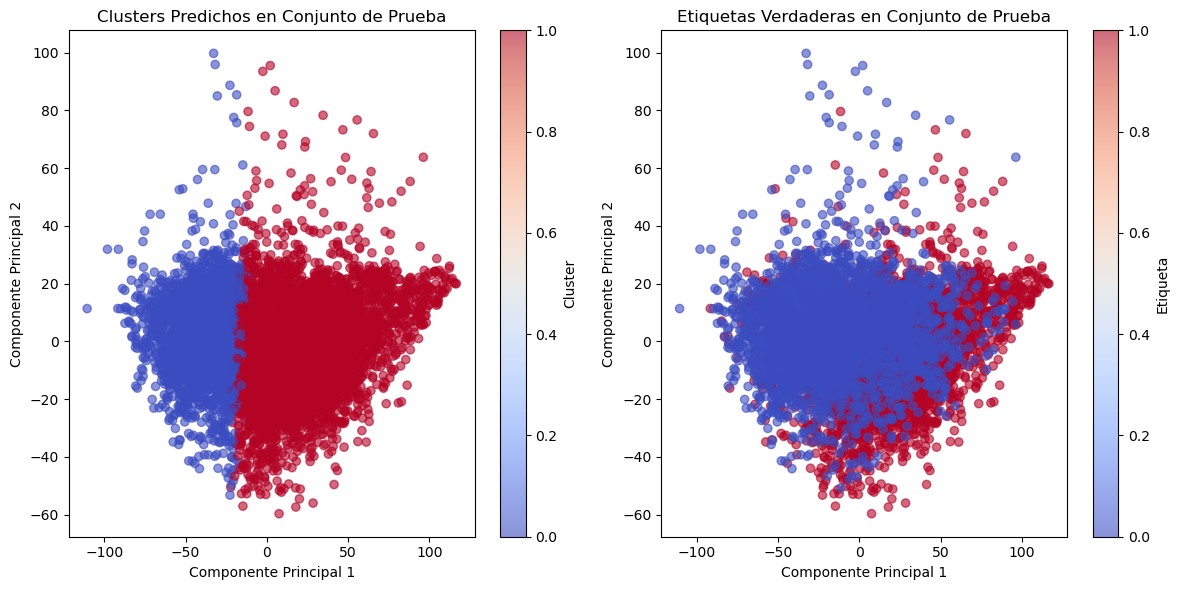

In [6]:
# Ruta del conjunto de prueba
test_dir = '/Users/alanmagno/Documents/datascience_paradigmas/datasets/covid/test_2'
test_file = '/Users/alanmagno/Documents/datascience_paradigmas/datasets/covid/datos_redimensionados_prueba.txt'

# Cargar datos de prueba
test_data = cargar_etiquetas(test_file, test_dir)
imagenes_test, etiquetas_test = cargar_imagenes(test_data)

# Normalización de las imágenes de prueba
imagenes_test_normalizadas = scaler.transform(imagenes_test)

# Aplicar PCA al conjunto de prueba
imagenes_test_pca = pca.transform(imagenes_test_normalizadas)

# Predicciones en el conjunto de prueba usando k-means entrenado
predicciones_test = kmeans.predict(imagenes_test_pca)

# Mapear clusters a etiquetas verdaderas
predicciones_asignadas_test = map_clusters_to_labels(etiquetas_test, predicciones_test)

# Evaluar precisión del modelo en el conjunto de prueba
precision_test = accuracy_score(etiquetas_test, predicciones_asignadas_test)
print(f"Precisión del modelo k-means en el conjunto de prueba: {precision_test:.2f}")

# Gráfica de comparación en el conjunto de prueba
pca_viz = PCA(n_components=2)
imagenes_test_pca_viz = pca_viz.fit_transform(imagenes_test_normalizadas)

plt.figure(figsize=(12, 6))

# Clusters predichos en conjunto de prueba
plt.subplot(1, 2, 1)
plt.scatter(imagenes_test_pca_viz[:, 0], imagenes_test_pca_viz[:, 1], c=predicciones_asignadas_test, cmap='coolwarm', alpha=0.6)
plt.title('Clusters Predichos en Conjunto de Prueba')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')

# Etiquetas verdaderas en conjunto de prueba
plt.subplot(1, 2, 2)
plt.scatter(imagenes_test_pca_viz[:, 0], imagenes_test_pca_viz[:, 1], c=etiquetas_test, cmap='coolwarm', alpha=0.6)
plt.title('Etiquetas Verdaderas en Conjunto de Prueba')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Etiqueta')

plt.tight_layout()
plt.show()


Advertencia: la imagen no se encontró en /Users/alanmagno/Documents/datascience_paradigmas/datasets/covid/train_2/path_redimensionada
Advertencia: la imagen no se encontró en /Users/alanmagno/Documents/datascience_paradigmas/datasets/covid/test_2/path_redimensionada
Precisión del modelo MiniBatch k-means en el conjunto de prueba: 0.50


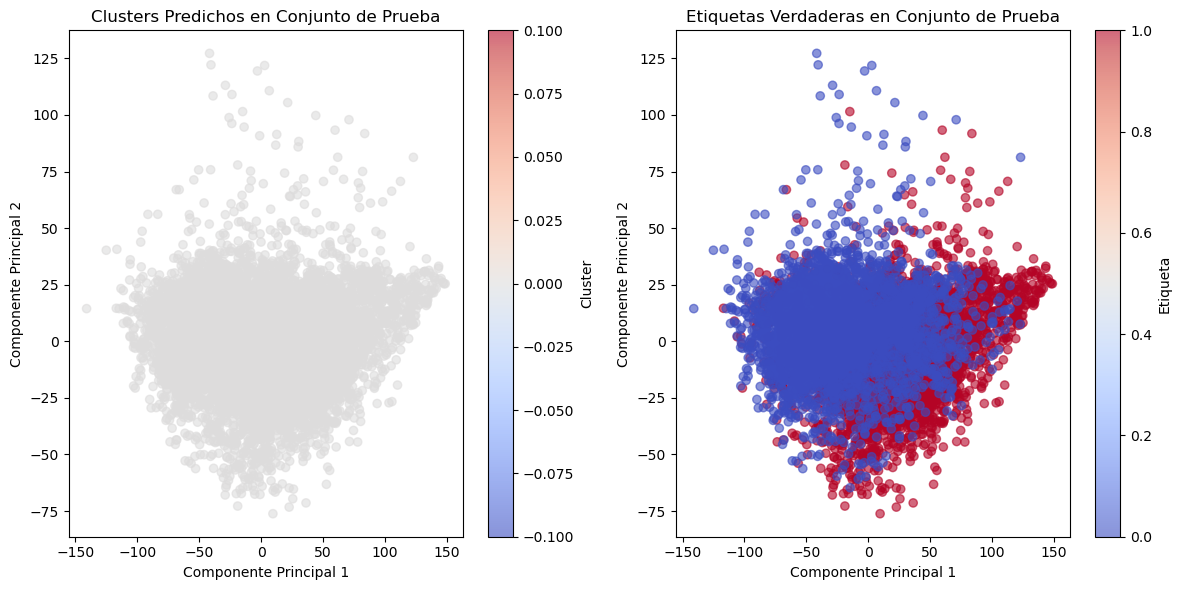

In [8]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from scipy.stats import mode

# Definir las rutas de los conjuntos de datos
train_dir = '/Users/alanmagno/Documents/datascience_paradigmas/datasets/covid/train_2'
test_dir = '/Users/alanmagno/Documents/datascience_paradigmas/datasets/covid/test_2'
train_file = '/Users/alanmagno/Documents/datascience_paradigmas/datasets/covid/datos_redimensionados_entrenamiento.txt'
test_file = '/Users/alanmagno/Documents/datascience_paradigmas/datasets/covid/datos_redimensionados_prueba.txt'

# Función para cargar etiquetas y rutas
def cargar_etiquetas(data_file, data_dir):
    data = pd.read_csv(data_file, sep=' ', header=None, names=['path', 'label', 'patient_id'])
    data['path'] = data['path'].apply(lambda x: os.path.join(data_dir, x.split('/')[-1]))  # Combina con el nombre de archivo
    data['label'] = data['label'].map({'positive': 1, 'negative': 0})  # Codificar etiquetas
    return data

# Función para cargar y procesar imágenes
def cargar_imagenes(data, image_size=(64, 64)):
    imagenes = []
    etiquetas = []
    for _, row in data.iterrows():
        img_path, label = row['path'], row['label']
        if os.path.exists(img_path):  # Verifica que la ruta de la imagen existe
            img = Image.open(img_path).convert('L').resize(image_size)  # Escala a escala de grises y cambia de tamaño
            imagenes.append(np.array(img).flatten())  # Aplanar la imagen
            etiquetas.append(label)
        else:
            print(f"Advertencia: la imagen no se encontró en {img_path}")
    return np.array(imagenes), np.array(etiquetas)

# Cargar y procesar imágenes de entrenamiento y prueba
train_data = cargar_etiquetas(train_file, train_dir)
test_data = cargar_etiquetas(test_file, test_dir)
imagenes_train, etiquetas_train = cargar_imagenes(train_data)
imagenes_test, etiquetas_test = cargar_imagenes(test_data)

# Normalización de las imágenes
scaler = StandardScaler()
imagenes_train_normalizadas = scaler.fit_transform(imagenes_train)
imagenes_test_normalizadas = scaler.transform(imagenes_test)

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=150)  # Aumentamos a 150 componentes
imagenes_train_pca = pca.fit_transform(imagenes_train_normalizadas)
imagenes_test_pca = pca.transform(imagenes_test_normalizadas)

# Normalización adicional posterior a PCA
pca_scaler = StandardScaler()
imagenes_train_pca = pca_scaler.fit_transform(imagenes_train_pca)
imagenes_test_pca = pca_scaler.transform(imagenes_test_pca)

# MiniBatchKMeans para agrupamiento
kmeans = MiniBatchKMeans(n_clusters=2, random_state=42, batch_size=50)
kmeans.fit(imagenes_train_pca)

# Predicciones en el conjunto de prueba
predicciones_test = kmeans.predict(imagenes_test_pca)

# Mapear clusters a etiquetas verdaderas
def map_clusters_to_labels(y_true, y_pred):
    labels = np.zeros_like(y_pred)
    for cluster in np.unique(y_pred):
        mask = (y_pred == cluster)
        labels[mask] = mode(y_true[mask])[0]
    return labels

predicciones_asignadas_test = map_clusters_to_labels(etiquetas_test, predicciones_test)

# Evaluación de precisión en el conjunto de prueba
precision_test = accuracy_score(etiquetas_test, predicciones_asignadas_test)
print(f"Precisión del modelo MiniBatch k-means en el conjunto de prueba: {precision_test:.2f}")

# Gráfica de comparación en el conjunto de prueba
pca_viz = PCA(n_components=2)
imagenes_test_pca_viz = pca_viz.fit_transform(imagenes_test_normalizadas)

plt.figure(figsize=(12, 6))

# Clusters predichos en conjunto de prueba
plt.subplot(1, 2, 1)
plt.scatter(imagenes_test_pca_viz[:, 0], imagenes_test_pca_viz[:, 1], c=predicciones_asignadas_test, cmap='coolwarm', alpha=0.6)
plt.title('Clusters Predichos en Conjunto de Prueba')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')

# Etiquetas verdaderas en conjunto de prueba
plt.subplot(1, 2, 2)
plt.scatter(imagenes_test_pca_viz[:, 0], imagenes_test_pca_viz[:, 1], c=etiquetas_test, cmap='coolwarm', alpha=0.6)
plt.title('Etiquetas Verdaderas en Conjunto de Prueba')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Etiqueta')

plt.tight_layout()
plt.show()


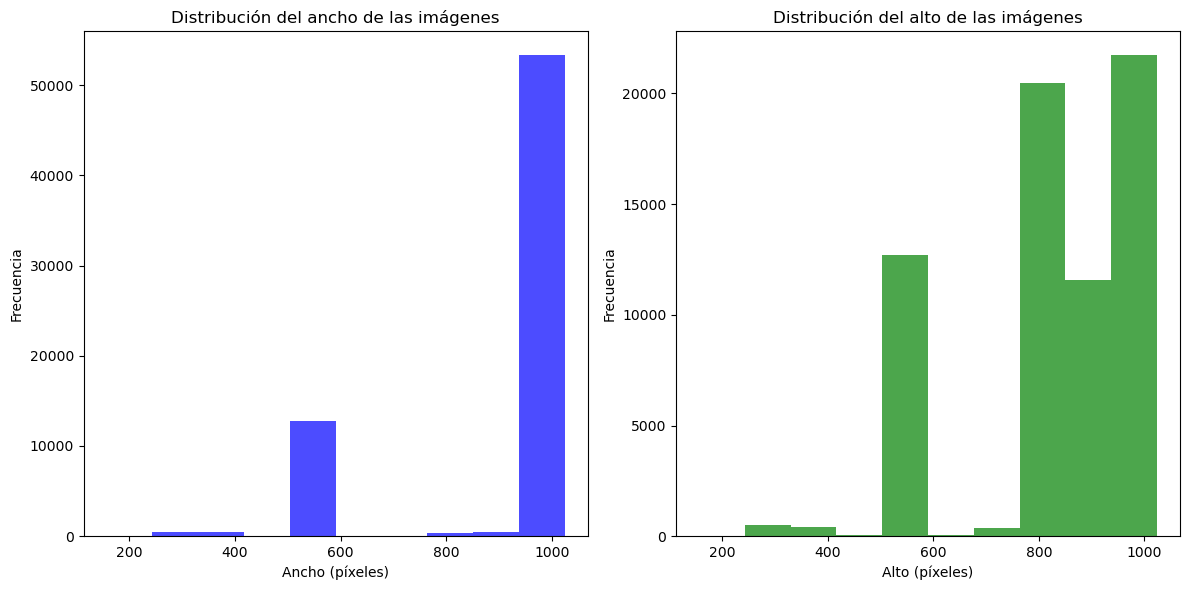

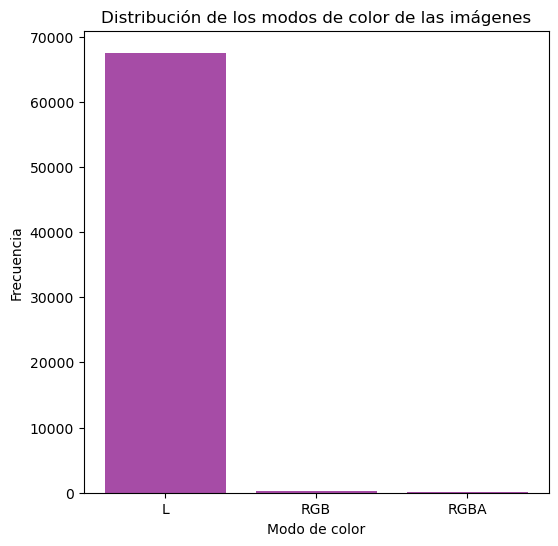

In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

# Ruta donde están almacenadas las imágenes
image_folder = '/Users/alanmagno/Documents/datascience_paradigmas/datasets/covid/train'

# Listas para almacenar las dimensiones (ancho, alto) y el modo de color
image_sizes = []
color_modes = []

# Recorrer cada archivo en la carpeta de imágenes
for filename in os.listdir(image_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        # Abrir la imagen
        image_path = os.path.join(image_folder, filename)
        with Image.open(image_path) as img:
            # Obtener dimensiones y modo de color
            image_sizes.append(img.size)  # (ancho, alto)
            color_modes.append(img.mode)

# Separar dimensiones en dos listas (ancho y alto)
widths, heights = zip(*image_sizes)

# Graficar histograma de dimensiones
plt.figure(figsize=(12, 6))

# Histograma del ancho
plt.subplot(1, 2, 1)
plt.hist(widths, bins=10, color='blue', alpha=0.7)
plt.title('Distribución del ancho de las imágenes')
plt.xlabel('Ancho (píxeles)')
plt.ylabel('Frecuencia')

# Histograma del alto
plt.subplot(1, 2, 2)
plt.hist(heights, bins=10, color='green', alpha=0.7)
plt.title('Distribución del alto de las imágenes')
plt.xlabel('Alto (píxeles)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Graficar histograma de modos de color
mode_counts = Counter(color_modes)
plt.figure(figsize=(6, 6))
plt.bar(mode_counts.keys(), mode_counts.values(), color='purple', alpha=0.7)
plt.title('Distribución de los modos de color de las imágenes')
plt.xlabel('Modo de color')
plt.ylabel('Frecuencia')
plt.show()


In [5]:
mode_counts = Counter(color_modes)
mode_counts

Counter({'L': 67512, 'RGB': 283, 'RGBA': 67})

In [3]:
import os

def contar_imagenes(carpeta):
    # Extensiones de archivos de imagen que se consideran
    extensiones_imagen = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')

    # Contar archivos que tienen una extensión de imagen
    contador = sum(1 for archivo in os.listdir(carpeta) if archivo.lower().endswith(extensiones_imagen))

    return contador

# Cambia 'ruta/de/tu/carpeta' por la ruta de la carpeta que quieres analizar
carpeta = '../../datasets/covid/escala_grises/proceso_etiquetas/etiquetas/magno/img'
print(f"Número de archivos de imagen en la carpeta: {contar_imagenes(carpeta)}")


Número de archivos de imagen en la carpeta: 200


In [10]:
def contar_textos(carpeta):
    # Extensiones de archivos de imagen que se consideran
    extensiones_imagen = ('.txt')

    # Contar archivos que tienen una extensión de imagen
    contador = sum(1 for archivo in os.listdir(carpeta) if archivo.lower().endswith(extensiones_imagen))

    return contador

carpeta1 = '../../datasets/covid/escala_grises/proceso_etiquetas/etiquetas/magno/etiquetas'
print(f"Número de archivos de imagen en la carpeta: {contar_textos(carpeta1)}")

Número de archivos de imagen en la carpeta: 202


In [9]:
import os
import shutil

def mover_archivos_texto(origen, destino):
    # Verificar si la carpeta de destino existe, si no, crearla
    if not os.path.exists(destino):
        os.makedirs(destino)

    # Recorrer los archivos en la carpeta de origen
    for archivo in os.listdir(origen):
        # Verificar si es un archivo de texto
        if archivo.lower().endswith('.txt'):
            ruta_origen = os.path.join(origen, archivo)
            ruta_destino = os.path.join(destino, archivo)

            # Mover el archivo solo si no existe en la carpeta de destino
            if not os.path.exists(ruta_destino):
                shutil.move(ruta_origen, ruta_destino)
                print(f"Archivo '{archivo}' movido a '{destino}'.")
            else:
                print(f"Archivo '{archivo}' ya existe en '{destino}', no se movió.")

# Cambia 'ruta/de/carpeta/origen' y 'ruta/de/carpeta/destino' por las rutas correspondientes
origen = '../../datasets/covid/escala_grises/proceso_etiquetas/etiquetas/magno/img'
destino = '../../datasets/covid/escala_grises/proceso_etiquetas/etiquetas/magno/etiquetas'
mover_archivos_texto(origen, destino)


Archivo 'sub-S323329_ses-E47067_run-1_bp-chest_vp-pa_cr-corrected.txt' movido a '../../datasets/covid/escala_grises/proceso_etiquetas/etiquetas/magno/etiquetas'.
Archivo 'classes.txt' ya existe en '../../datasets/covid/escala_grises/proceso_etiquetas/etiquetas/magno/etiquetas', no se movió.
Archivo 'sub-S322034_ses-E44615_run-1_bp-chest_vp-ap_dx-corrected.txt' movido a '../../datasets/covid/escala_grises/proceso_etiquetas/etiquetas/magno/etiquetas'.
Archivo 'sub-S316726_ses-E35404_run-1_bp-chest_vp-ap_cr-corrected.txt' movido a '../../datasets/covid/escala_grises/proceso_etiquetas/etiquetas/magno/etiquetas'.
Archivo 'sub-S327067_ses-E54348_run-1_bp-chest_vp-ap_dx-corrected.txt' movido a '../../datasets/covid/escala_grises/proceso_etiquetas/etiquetas/magno/etiquetas'.
Archivo 'sub-S323173_ses-E71653_run-1_bp-chest_vp-ap_dx-corrected.txt' movido a '../../datasets/covid/escala_grises/proceso_etiquetas/etiquetas/magno/etiquetas'.
Archivo 'sub-S323769_ses-E47839_run-1_bp-chest_vp-pa_dx-corr

In [11]:
import os

def verificar_archivos_asociados(carpeta_imagenes, carpeta_textos):
    # Extensiones de archivos de imagen a considerar
    extensiones_imagen = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')
    faltantes = []  # Lista para almacenar nombres de imágenes sin archivo de texto asociado

    # Recorrer todos los archivos de imagen en la carpeta de imágenes
    for archivo_imagen in os.listdir(carpeta_imagenes):
        # Verificar si el archivo tiene una extensión de imagen
        if archivo_imagen.lower().endswith(extensiones_imagen):
            # Obtener el nombre del archivo sin extensión
            nombre_base = os.path.splitext(archivo_imagen)[0]
            # Crear la ruta esperada del archivo de texto en la carpeta de textos
            archivo_texto = f"{nombre_base}.txt"
            ruta_texto = os.path.join(carpeta_textos, archivo_texto)

            # Verificar si el archivo de texto existe
            if not os.path.exists(ruta_texto):
                faltantes.append(nombre_base)  # Agregar a la lista si falta el archivo

    # Resultados
    if faltantes:
        print("Faltan archivos de texto para las siguientes imágenes:")
        for nombre in faltantes:
            print(f"- {nombre}")
    else:
        print("Todos los archivos de imagen tienen su archivo de texto asociado.")

# Cambia 'ruta/de/carpeta/imagenes' y 'ruta/de/carpeta/textos' por las rutas correspondientes
carpeta_imagenes = '../../datasets/covid/escala_grises/proceso_etiquetas/etiquetas/magno/img'
carpeta_textos = '../../datasets/covid/escala_grises/proceso_etiquetas/etiquetas/magno/etiquetas'
verificar_archivos_asociados(carpeta_imagenes, carpeta_textos)


Todos los archivos de imagen tienen su archivo de texto asociado.
